In [32]:
!python --version

Python 3.7.0


In [33]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [34]:
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:



In [35]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [37]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.path.abspath("..\\..\\")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [38]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "hat"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1
    
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + safety_hat,

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    LEARNING_RATE = 0.001

In [39]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

model_path = 'C:\\Users\\Zakar\\Desktop\\Mask_RCNN\\logs\\hat20241107T1611\\mask_rcnn_hat_0020.h5'

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)




Loading weights from  C:\Users\Zakar\Desktop\Mask_RCNN\logs\hat20241107T1611\mask_rcnn_hat_0020.h5
Re-starting from epoch 20


In [40]:
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):
        self.add_class("hat", 1, "hat")
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, "safety_hat_json.json")))

        for image_id, info in annotations.items():
            polygons = [region['shape_attributes'] for region in info['regions']]
            objects = [region['region_attributes']['safety_hat'] for region in info['regions']]
            num_ids = [1 if name == "hat" else 0 for name in objects]
            image_path = os.path.join(dataset_dir, info['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "hat",
                image_id=info['filename'],
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "hat":
            return super(self.__class__, self).load_mask(image_id)
        
        num_ids = image_info['num_ids']
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(image_info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    #def image_reference(self, image_id):
     #   return self.image_info[image_id]["path"]
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)    


In [41]:
# Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom("C:\\Users\\Zakar\\Desktop\\Mask_RCNN\\samples\\hats\\datasets", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom("C:\\Users\\Zakar\\Desktop\\Mask_RCNN\\samples\\hats\\datasets", "val")
dataset_val.prepare()
    
print(f"Loaded {len(dataset_val.image_ids)} images in the validation dataset.")

Loaded 30 images in the validation dataset.


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   42.00000  max:  569.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


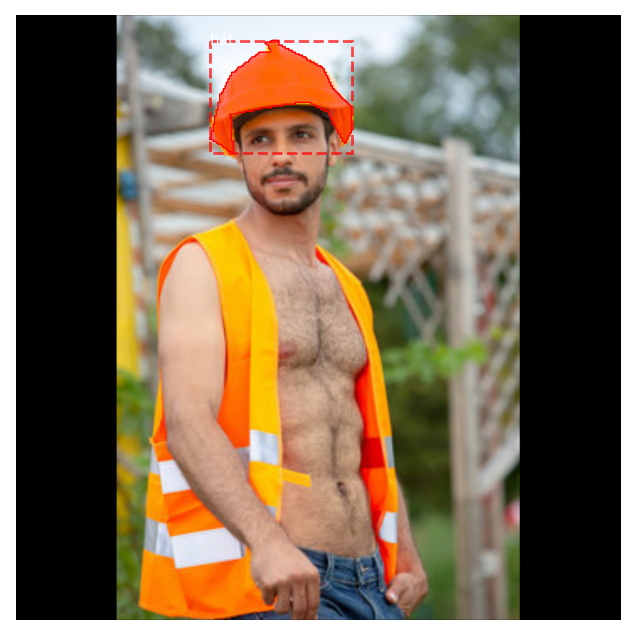

In [42]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

# Testing on all unseen images at once

Processing 1 images
image                    shape: (1024, 800, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


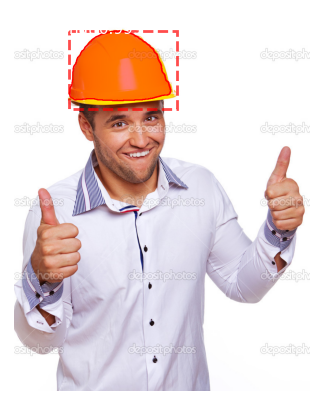

Processing 1 images
image                    shape: (747, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


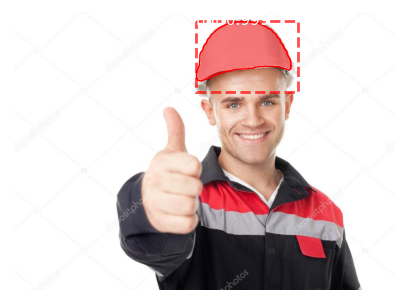

Processing 1 images
image                    shape: (589, 589, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


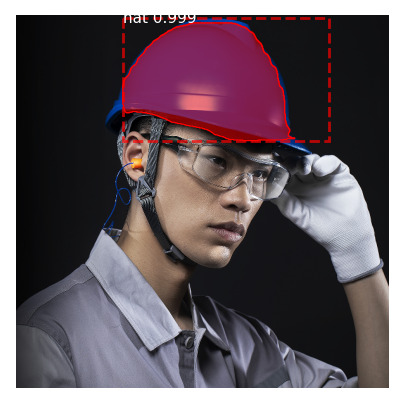

Processing 1 images
image                    shape: (736, 736, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


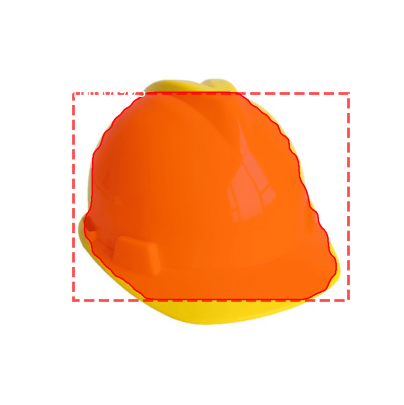

Processing 1 images
image                    shape: (896, 1152, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1152.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


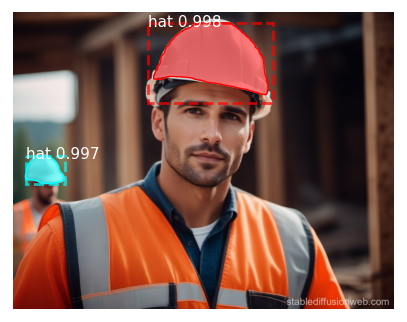

Processing 1 images
image                    shape: (1024, 681, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


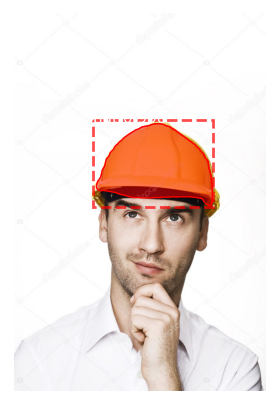

In [43]:
import skimage
import os
import numpy as np

real_test_dir = 'C:\\Users\\Zakar\\Desktop\\Mask_RCNN\\samples\\hats\\test_images'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    # Check if image has 4 channels (RGBA) and convert it to RGB (3 channels)
    if img.shape[-1] == 4:
        img = img[:, :, :3]  # Remove the alpha channel
    
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))


In [44]:
#!pip install numpy==1.20.3
#!pip install seaborn
#!pip install sklearn
#!pip install scikit-learn

# Confusion Matrix on Validation Dataset


In [45]:
import numpy as np
import os
import pandas as pd

# Define the function to compare ground truth and predictions
def gt_pred_lists(gt_class_id, gt_bbox, pred_class_id, pred_bbox):
    """
    This function compares the ground truth bounding boxes with the predicted bounding boxes.
    It returns two lists: one for ground truth and one for predictions.

    Args:
    - gt_class_id: Ground truth class IDs
    - gt_bbox: Ground truth bounding boxes (shape: [N, 4])
    - pred_class_id: Predicted class IDs
    - pred_bbox: Predicted bounding boxes (shape: [M, 4])

    Returns:
    - gt: List of ground truth class IDs
    - pred: List of predicted class IDs
    """
    gt = []
    pred = []

    # Add ground truth class IDs to gt list
    for i in range(len(gt_class_id)):
        gt.append(gt_class_id[i])

    # Add predicted class IDs to pred list
    for i in range(len(pred_class_id)):
        pred.append(pred_class_id[i])

    return np.array(gt), np.array(pred)


# Assuming inference_config and dataset_val are defined elsewhere in your code
config = inference_config
dataset = dataset_val

gt_tot = np.array([])
pred_tot = np.array([])

# mAP list
mAP_ = []

# Compute gt_tot, pred_tot, and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        modellib.load_image_gt(dataset, config, image_id)  # Load image data
    info = dataset.image_info[image_id]  # Get image info

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]  # Get the results

    # Compute gt_tot and pred_tot using the custom gt_pred_lists function
    gt, pred = gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    
    # Check if lengths of gt and pred match
    if len(gt) != len(pred):
        # If they don't match, append NaNs to balance the length
        max_len = max(len(gt), len(pred))
        gt = np.pad(gt, (0, max_len - len(gt)), constant_values=np.nan)
        pred = np.pad(pred, (0, max_len - len(pred)), constant_values=np.nan)

    # Append to totals
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)

    # Compute precision, recall, AP
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                          r['rois'], r['class_ids'], r['scores'], r['masks'])

    # Check if the vectors len are equal
    print("The actual length of the gt vector is:", len(gt_tot))
    print("The actual length of the pred vector is:", len(pred_tot))

    mAP_.append(AP_)
    print("Average precision of this image:", AP_)
    print("The current mean average precision for the whole images:", sum(mAP_) / len(mAP_))

# Convert gt_tot and pred_tot to integer arrays
gt_tot = gt_tot.astype(int)
pred_tot = pred_tot.astype(int)

# Save the vectors of gt and pred
save_dir = "output"
gt_pred_tot_json = {"gt_tot": gt_tot, "pred_tot": pred_tot}
df = pd.DataFrame(gt_pred_tot_json)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

df.to_json(os.path.join(save_dir, "gt_pred_test.json"))


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
The actual length of the gt vector is: 1
The actual length of the pred vector is: 1
Average precision of this image: 1.0
The current mean average precision for the whole images: 1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
The actual length 

The actual length of the gt vector is: 16
The actual length of the pred vector is: 16
Average precision of this image: 1.0
The current mean average precision for the whole images: 1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
The actual length of the gt vector is: 17
The actual length of the pred vector is: 17
Average precision of this image: 1.0
The current mean average precision for the whole images: 1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas           

molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
The actual length of the gt vector is: 32
The actual length of the pred vector is: 32
Average precision of this image: 1.0
The current mean average precision for the whole images: 1.0


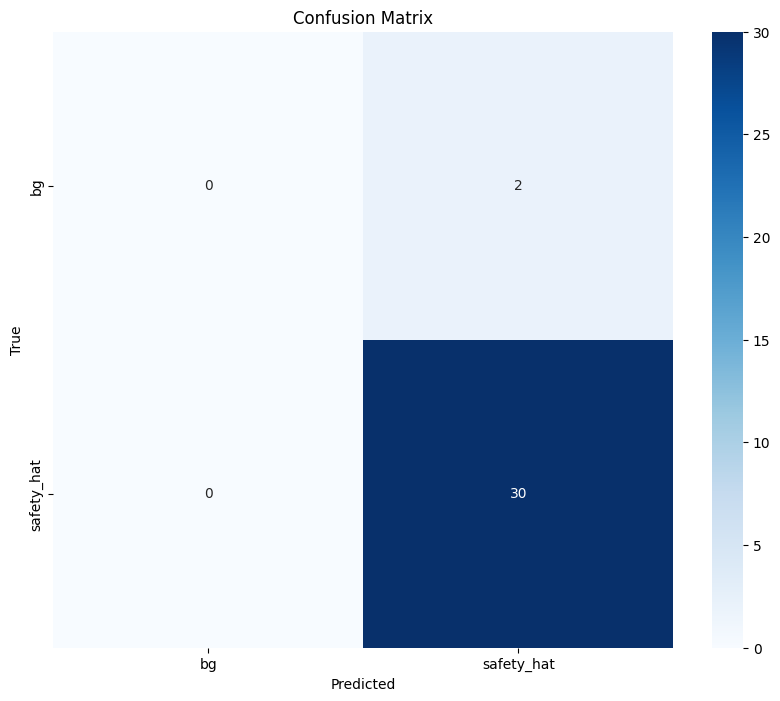

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(gt_tot, pred_tot)

# Define class labels (as per your dataset)
labels = ["bg", "safety_hat"]

# Plot confusion matrix
plot_confusion_matrix(cm, labels=labels, figsize=(10, 8))


In [47]:
# Assuming the confusion matrix 'cm' has been calculated
# Extract True Positives (TP), False Positives (FP), and False Negatives (FN)
tp = np.diagonal(cm)  # True Positives are on the diagonal
fp = np.sum(cm, axis=0) - tp  # False Positives are the sum of columns minus the diagonal
fn = np.sum(cm, axis=1) - tp  # False Negatives are the sum of rows minus the diagonal

print("True Positives for each class:", tp)
print("False Positives for each class:", fp)
print("False Negatives for each class:", fn)

# Eliminate the background class (class 0) from tp, fp, and fn
tp = tp[1:]  # Exclude background class (index 0)
fp = fp[1:]  # Exclude background class (index 0)
fn = fn[1:]  # Exclude background class (index 0)

print("\n########################\n")
print("tp for each class:", tp)
print("fp for each class:", fp)
print("fn for each class:", fn)


True Positives for each class: [ 0 30]
False Positives for each class: [0 2]
False Negatives for each class: [2 0]

########################

tp for each class: [30]
fp for each class: [2]
fn for each class: [0]


# The graph representing the train and validation losses



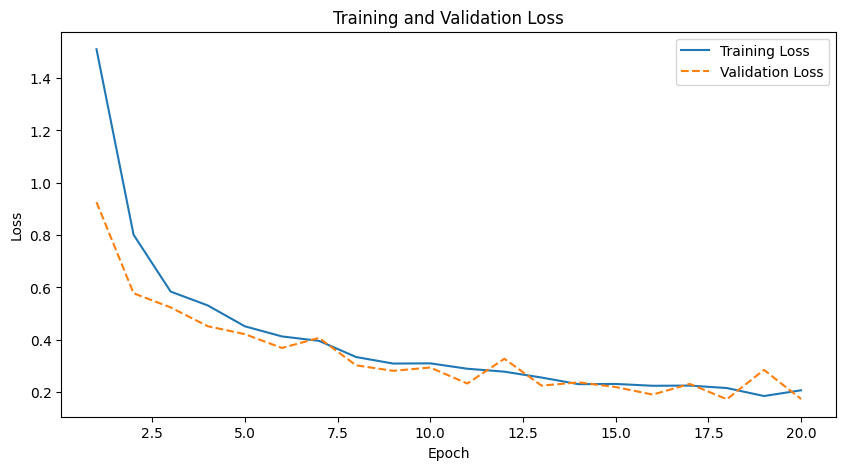

In [49]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store loss data
train_losses = []
val_losses = []

# Regular expressions for training and validation loss lines
train_loss_pattern = r"loss: ([0-9.]+)"
val_loss_pattern = r"val_loss: ([0-9.]+)"

# Read and parse log file
with open('C:\\Users\\Zakar\\Desktop\\Mask_RCNN\\samples\\hats\\logs.txt', 'r') as file:
    for line in file:
        # Search for training loss
        train_loss_match = re.search(train_loss_pattern, line)
        if train_loss_match:
            train_losses.append(float(train_loss_match.group(1)))
        
        # Search for validation loss
        val_loss_match = re.search(val_loss_pattern, line)
        if val_loss_match:
            val_losses.append(float(val_loss_match.group(1)))

# Check if data lengths match
if len(train_losses) != len(val_losses):
    print("Warning: Mismatch in training and validation loss lengths.")
else:
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


# CONCLUSION

In [51]:

#The Safety Hat Detection model shows strong performance in identifying safety hats in various scenarios,with high precision and recall.
#Further improvements can be achieved by increasing the dataset size and incorporating additional training techniques.